In [190]:
%matplotlib notebook

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil

from IPython.display import display, Image
from scipy import interpolate
from scipy import integrate
from astropy.io import ascii
from astropy.wcs import WCS
from matplotlib.ticker import AutoMinorLocator


# Data

In [191]:
field = 'Goodss/'
way  = 'tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'
name_cat = 'goodss_3dhst.v4.1.cat'

In [192]:
# Load all model spectra and main catalog
list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(name_cat, skip_header=2) 
#main_cat = np.genfromtxt(field + name_cat, skip_header=2) 


In [193]:
np.shape(main_cat)

(50507, 141)

In [194]:
# Load transmission curves from fortran code by AKI
mar = np.genfromtxt('scor01.txt')
z_tr = mar[:,2]
lam_tr = mar[:,1]
tra_f =  mar[:,0]


<IPython.core.display.Javascript object>


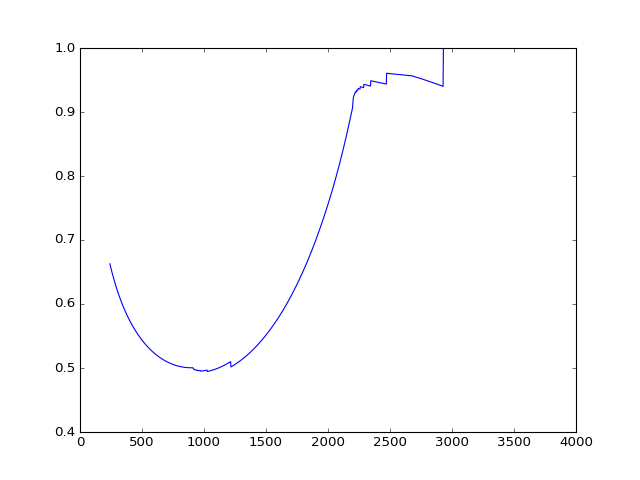

In [195]:
# just for checking myself
kol = (z_tr==1.41)
plt.close()
plt.plot(lam_tr[kol], tra_f[kol])


# Functions and constants

In [196]:
# Number of object 
#id = 28720
#id = 24315
#id = 27706  
#id = 5647 
#id = 10771
#id = 15524
#id = 20612
#id = 15654
id = 28664

# Cosmological constants
Omega_M = 0.2726             # Density of matter
Omega_K =  0.0               # Density of curvature
Omega_L = 0.7274             # Density of dark energy
h = 0.704

# For reference
c = 2.9927e10
pi = 3.14159265


# Collection of additional distance functions  
E   = lambda x: 1/np.sqrt(Omega_M * np.power(1+x,3) + Omega_L + Omega_K * np.power(1+x,2))
D_c = lambda x: (9.26e27/h) * integrate.quad(E, 0, x)[0]                                 # In centimeters
D_m = lambda x: D_c(x)
D_A = lambda x: D_m(x)/(1+x)
D_L = lambda x: np.power(1+x, 2) * D_A(x)

In [197]:
# The function of shifting the wavelength and modification amplitude of the flux
def func_1(z, n, x, y):
    l_mod  = (1+z) * x
    mod_flux = n * y
    return l_mod, mod_flux

In [237]:
# A function that takes into account the transmission curves and response function from each filter
def chi2(z, n, lcii, x, y, fil, lam_tr, flux_tr, z_tr, toplot=False):
    
    z = float("{0:.2f}".format(z))
    
    # Find the template corresponding to our z and n
    l_obs2, moh = func_1(z, n, x, y)
    lcii = np.array(lcii)


    # Add absorption for object
    con = (z_tr == z)
    lam_tr = lam_tr[con]
    flux_tr = flux_tr[con]
    tra_func = np.interp(l_obs2, lam_tr, flux_tr)
    
    
    # working with type
    l_obs2 = np.array(l_obs2)
    moh = np.array(moh)
    
    sp_ext = np.zeros(len(l_obs2))
    for i in range (len(l_obs2)): 
        sp_ext[i] =  tra_func[i] * moh[i] 
    

    # Sorting
    sp_ext = sp_ext[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]

    
    
    fit = []
    
    
    # Add response function for all filters
    for i in range(len(fil)):
        num = 0
        spectr = sp_ext.copy()
        
        res, n = get_filter_by_id(fil[i])
        
        # Load lambda and flux from response function
        x_res = res[:, 1]
        y_res = res[:, 2]
        
        x_filt = np.array(x_res)
        y_filt = np.array(y_res)
        
        
        lim1 = min(x_res)
        lim2 = max(x_res)
        
        # Load template lambda
        xx_tem = l_obs2[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]]
        
        
        filt_int  = np.interp(xx_tem, x_filt, y_filt) 
        
        num = np.trapz(spectr[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]]*filt_int, xx_tem) /lcii[i]
        
        
        fit.append(num*10**30)
        
        print("filter", n)
     
        
        
        
        #if i == 3:
            #print("fit", fit)
            #print('spec',  spectr[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]])
            #print( "filt_int", filt_int)
            #print(len(spectr), len(l_obs2))
            #print(spectr)
            #print(len(xx_tem), len(filt_int), len(spectr[np.where((l_obs2 >= lim1) & (l_obs2 <= lim2))[0]]))
            #print("")
            #print(lim1, lim2)
            #plt.close()
            #plt.plot(l_obs2, spectr)
            #plt.show()

    return fit

In [134]:
#tz = chi2(3.01, 1000, lci, x, y, num_fil, mar[:,1],  mar[:,0], mar[:,2])


# Fluxes and wavelengths

In [199]:
# The column numbers of the flux in the main catalog
num_fc  = np.array(([18, 30, 39, 48, 75, 78, 81, 84, 57, 66, \
                     72, 21, 24, 36, 42, 15, 12, 87, 89, 91, \
                     93, 95, 97, 99, 101, 103, 105, 107, 109, 111, \
                     113, 54, 63, 9, 60, 69, 27, 45, 51, 33]))


# The column numbers of the errors in the main catalog
num_efc = np.array(([19, 31, 40, 49, 76, 79, 82, 85, 58, 67, \
                     73, 22, 25, 37, 43, 16, 13, 88, 90, 92,  \
                     94, 96, 98, 100, 102, 104, 106, 108, 110, 112, \
                     114, 55, 64, 10, 61, 70, 28, 46, 52, 34]))

# Name of filters
fil_cat = ['F435', 'F606W', 'F775W', 'F850LP', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'J', 'H', \
           'Ks', 'B', 'V', 'Rc',  'I', 'U', 'U38', 'IA427', 'IA445', 'IA505', 'IA527', 'IA550', \
           'IA574', 'IA598', 'IA624', 'IA651', 'IA679', 'IA738', 'IA767', 'IA797', 'IA856', 'F125W', \
           'F140W', 'F160W', 'tenisJ',  'tenisK', 'F606cand',  'F814Wcand', 'F850LPcand', 'R' ]


# Central wavelengths of filters
#lambd = np.array(([0.4318, 0.5919, 0.7693, 0.9036, 3.5569, 4.5020, 5.7450, 7.9158, 1.2356, 1.6496, \
#                   2.1667, 0.4563, 0.5396, 0.6517, 0.7838, 0.3750, 0.3637, 0.4260, 0.4443, 0.5061, \
#                   0.5259, 0.5495, 0.5763, 0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966,\
#                   0.8565, 1.2471, 1.3924, 1.5396, 1.2530, 2.1574, 0.5921, 0.8057, 0.9033, 0.6443
#                  ]))

# Central wavelengths of filters
lambd = np.array(([0.4318, 0.5919, 0.7693, 0.9036, 3.5569, 4.5020, 5.7450, 7.9158, 1.2356, 1.6496, \
                   2.1667, 0.4563, 0.5396, 0.6517, 0.7838, 0.3750, 0.3637, 0.4260, 0.4443, 0.5061, \
                   0.5763, 0.5495, 0.5763, 0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966,\
                   0.8565, 1.2471, 1.3924, 1.5396, 1.2530, 2.1574, 0.5921, 0.8057, 0.9033, 0.6443
                  ]))

In [200]:
id

28664

In [201]:
# Spectrum from the catalog HST
flux_c = []
erflu_c = []
filt = []

for j in range(len(num_fc)):
    for i in range(len(main_cat[0, :])):
        if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
            flux_c.append(main_cat[id - 1, i])
            erflu_c.append(main_cat[id - 1, int(num_efc[j])])
            filt.append(j)


In [202]:
#np.array(fil_cat)[filt]  # all filters that have flux for our object (id)
print(len(filt), len(flux_c))

12 12


In [139]:
# Translate the wavelength into angstroms
lci = lambd[filt] * 10 ** 4

# Reproduce to a good type
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Translate the flow into nano Jansky
flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]
erflu_c = [erflu_c[i] * 10**(2.56) for i in range(len(erflu_c))]

# Reproduce to a good type again
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Sorting

#flux_c = flux_c[np.argsort(lci)]
#erflu_c = erflu_c[np.argsort(lci)]
#lci = lci[np.argsort(lci)]

In [203]:
lci

array([  4318.,   4563.,   5396.,   5061.,   5763.,  12471.,  13924.,
        15396.,  12530.,   5921.,   8057.,   9033.])

<IPython.core.display.Javascript object>


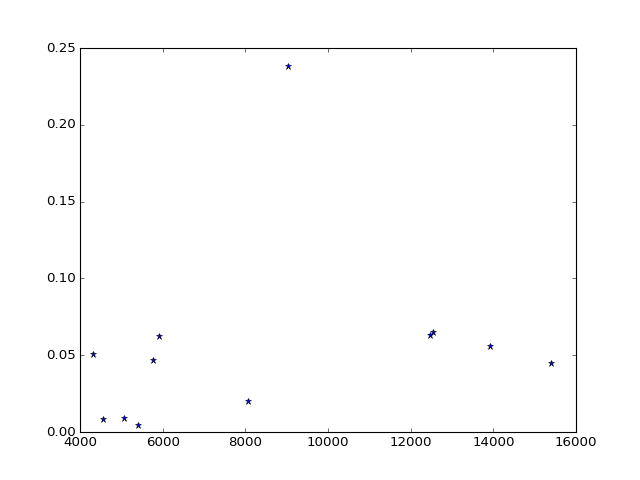

In [204]:
# just for checking myself
plt.close()
plt.plot(lci, flux_c, '*') # - spectrum from catalog for id object  

# Response functions 

In [205]:
#fname = field + 'Eazy/' + 'goodss_3dhst.v4.1.translate'
fname = 'goodss_3dhst.v4.1.translate'
filt_list = np.genfromtxt(fname, dtype=None)


fil = []
num_fil = []
for i, j in zip(filt_list[:, 1], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        num_fil.append(np.array(i[1:]).astype(int))
        # print(np.array(i[1:]).astype(int))

        
for i, j in zip(filt_list[:, 0], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        fil.append(np.array(i[2:]).astype(str))
        

num_fil = np.array(num_fil)
fil = np.array(fil)

# Filters and their numbers
fil = fil[np.argsort(num_fil)]
num_fil = num_fil[np.argsort(num_fil)]

# Delete filters that are not in the article
hi = [19, 20, 29, 33]
num_fil = np.delete(num_fil, hi)
fil = np.delete(fil, hi)

In [206]:
filters_info = []
for line in open( 'FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)

In [207]:
temp_filters = open('FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

l = 0
for line in temp_filters:

    if line[0] == ' ':

        if not first:
            filters.append(np.array(temp))
            l += 1

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))
        
# filters - include response function for each filter
# filters_name - include all filters name

filters = np.array(filters)
filters_names = np.array(filters_names)


In [208]:
# It return name and response function for each filter by id in num_fil
def get_filter_by_id(id):
    temp = np.array([a[0] for a in filters_info]).astype(int)
    name = filters_info[np.where(temp == id)[0][0]][1]
    names = np.array([a[1] for a in filters_names])
    lam =  np.array([a[4] for a in filters_info[np.where(name == names)[0]]])
    #   print name
    return filters[np.where(name == names)[0][0]], name

In [209]:
#filters_names[num_fil[filt]]


In [210]:
# Take for response function only those filters which have flux in data
num_fil = num_fil[filt]

In [211]:
num_fil

array([  1,  46,  50, 185, 188, 203, 204, 205, 220, 236, 239, 240])

<IPython.core.display.Javascript object>


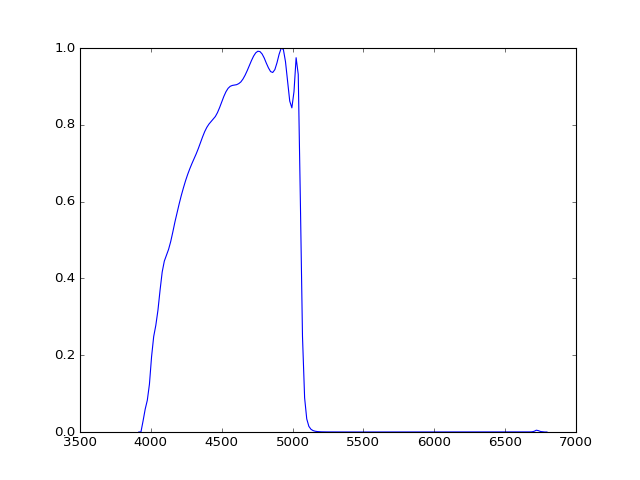

musyc/B_cdfs_tot.dat


In [230]:
# just for checking myself
p8,p9 = get_filter_by_id(46)
p1 = p8[:, 1]
p2 = p8[:, 2]
plt.close()
plt.plot(p1,p2)
print(p9)

# MAIN CYCLE

In [75]:
# just for checking myself
list[2]

'tweak_cosmos_v4/eazy_v1.1_sed3.dat'

In [187]:
z_list = np.arange(0.01, 10, 0.05)
n_list = np.logspace(-6, 1, 200)

L = np.ones((len(n_list), len(z_list)))
k = 0


# Template wavelengths and fluxes
x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]


for j in range(len(z_list)):
        fitz = chi2(z_list[j], 1, lci, x, y, num_fil, mar[:,1],  mar[:,0], mar[:,2])
        for i in range(len(n_list)):
        
            L[i,j] = np.sum( (flux_c - n_list[i]*np.array(fitz)) ** 2 / (erflu_c ** 2) )
            #print(np.shape(L))
          
            
H = np.amin(L, axis = 0)
PZ = H
#plt.close()
#plt.plot(z_list, np.exp(-(PZ - np.min(PZ))))
#print(L)

In [154]:
num_fil

array([  1,  46,  50, 185, 188, 203, 204, 205, 220, 236, 239, 240])

In [153]:
flux_c

array([ 18.41205124,   3.13772055,   1.59391266,   3.20561615,
        17.10242869,  22.8648405 ,  20.31276485,  16.28622922,
        23.70718159,  22.58708579,   7.30912432,  86.56180212])

In [262]:
z_list = np.arange(1.86, 9.96, 0.05)
#n_list = np.logspace(-6, 1, 6)

print(z_list)
L = np.ones((len(z_list)))
k = 2


# Template wavelengths and fluxes
x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]

print(L)

print("")
for i in range(len(z_list)):
    
    l1 = 0
    l2 = 0
    print("z=", z_list[i])
    print('')
    print("")
    fitz = chi2(z_list[i], 1, lci, x, y, num_fil, mar[:,1],  mar[:,0], mar[:,2])
    
    n=[]
    print('fit', fitz)
    for j in range(len(num_fil)):
        n.append( (2*np.array(fitz)[j]*flux_c[j]) / (2*np.array(fitz)[j]**2) )
     
    print("len", len(n), len(fitz), len(flux_c))
    for k in range(len(fitz)):
        if fitz[k] != 0:
            l1 +=  np.array((flux_c[k] - np.array(n)[k]*np.array(fitz)[k]))** 2 / (np.array(erflu_c)[k] ** 2)
            
        if fitz[k] ==0:
            l2 += flux_c[k]**2 / (np.array(erflu_c)[k] ** 2) 
            print("L2", l2)
    
    L[i] = (l1 + l2)*10**30 
    print('')
    print("")
    print('')
    print("")
    print('')
    print("")

print("L",L)

    
           
          
            

[ 1.86  1.91  1.96  2.01  2.06  2.11  2.16  2.21  2.26  2.31  2.36  2.41
  2.46  2.51  2.56  2.61  2.66  2.71  2.76  2.81  2.86  2.91  2.96  3.01
  3.06  3.11  3.16  3.21  3.26  3.31  3.36  3.41  3.46  3.51  3.56  3.61
  3.66  3.71  3.76  3.81  3.86  3.91  3.96  4.01  4.06  4.11  4.16  4.21
  4.26  4.31  4.36  4.41  4.46  4.51  4.56  4.61  4.66  4.71  4.76  4.81
  4.86  4.91  4.96  5.01  5.06  5.11  5.16  5.21  5.26  5.31  5.36  5.41
  5.46  5.51  5.56  5.61  5.66  5.71  5.76  5.81  5.86  5.91  5.96  6.01
  6.06  6.11  6.16  6.21  6.26  6.31  6.36  6.41  6.46  6.51  6.56  6.61
  6.66  6.71  6.76  6.81  6.86  6.91  6.96  7.01  7.06  7.11  7.16  7.21
  7.26  7.31  7.36  7.41  7.46  7.51  7.56  7.61  7.66  7.71  7.76  7.81
  7.86  7.91  7.96  8.01  8.06  8.11  8.16  8.21  8.26  8.31  8.36  8.41
  8.46  8.51  8.56  8.61  8.66  8.71  8.76  8.81  8.86  8.91  8.96  9.01
  9.06  9.11  9.16  9.21  9.26  9.31  9.36  9.41  9.46  9.51  9.56  9.61
  9.66  9.71  9.76  9.81  9.86  9.91  9.96]
[ 1.  1

/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [260]:
np.exp(-L)

array([ 0.78561611,  0.72236175,  0.93509558,  0.85018836,  0.91840193,
        0.88830092,  0.78204173,  0.93509558,  0.88909888,  0.74417157,
        0.92867557,  0.82464979,  0.84235039,  0.93754887,  0.95428723,
        0.84879804,  0.80877077,  0.79010602,  0.74829305,  0.76289499,
        0.87129281,  0.8969715 ,  0.66269724,  0.9163468 ,  0.5987845 ,
        0.83598134,  0.68126333,  0.76622795,  1.        ,  0.88909888,
        0.97468705,  0.69000613,  0.83662152,  0.77498325,  0.91035145,
        0.84743857,  0.74011453,  0.84432425,  0.91095357,  0.75638853,
        0.66321439,  0.94054542,  0.97301726,  0.70142816,  0.8332    ,
        0.85459172,  0.84393809,  0.97418231,  0.87423912,  0.80658841,
        0.80282823,  0.94833194,  0.82252575,  0.89218176,  0.85624052,
        0.92741774,  0.84072834,  0.84287137,  0.80320798,  0.78164976,
        0.82942761,  1.        ,  0.84879804,  0.96860445,  0.91822075,
        0.87019151,  0.86453424,  0.77749794,  0.84595324,  0.85

<IPython.core.display.Javascript object>


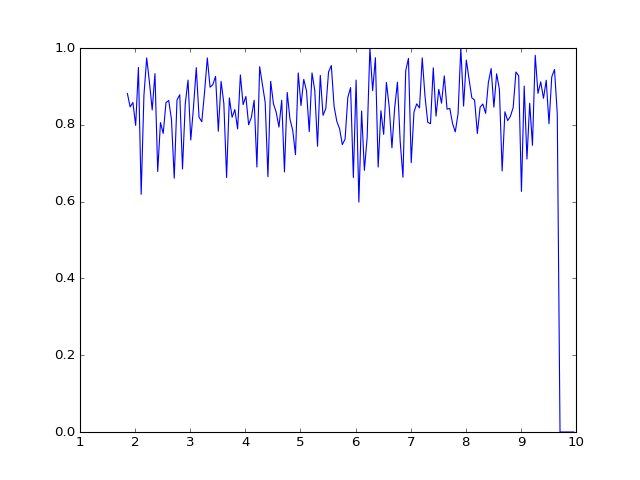

In [263]:
plt.close()
plt.plot(z_list, np.exp(-L))
plt.xlim(1, 10)
plt.show()

<IPython.core.display.Javascript object>


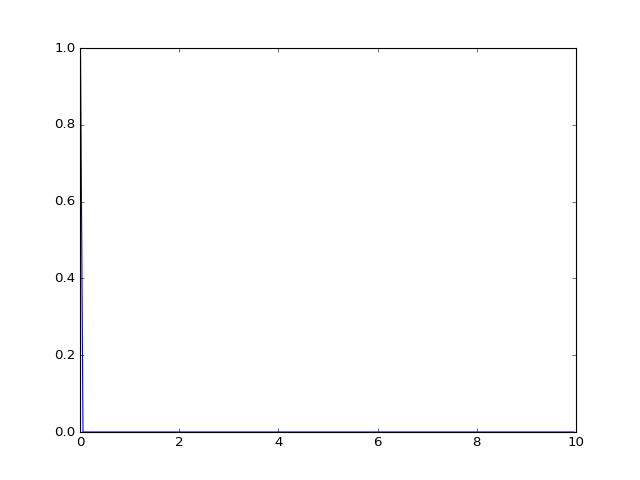

In [146]:
#folder = 'one/'
#folder = 'zero.one/'
#folder = 'zero/'
#folder = '3_t_zero.one/'
folder = 'one_t_zero.one/'


# P(z) from eazy code with the fifth template
pzz3 = np.genfromtxt(folder + 'goodss_3dhst.v4.1_27706.pz', skip_header=0)
fik = (pzz3[:,2]==1)
pz3 = np.exp(-0.5 * (pzz3[:,1][fik]- np.min(pzz3[:,1][fik])))
zgrid3 = pzz3[:,0][fik]
plt.close()
plt.plot(zgrid3, pz3)


<IPython.core.display.Javascript object>


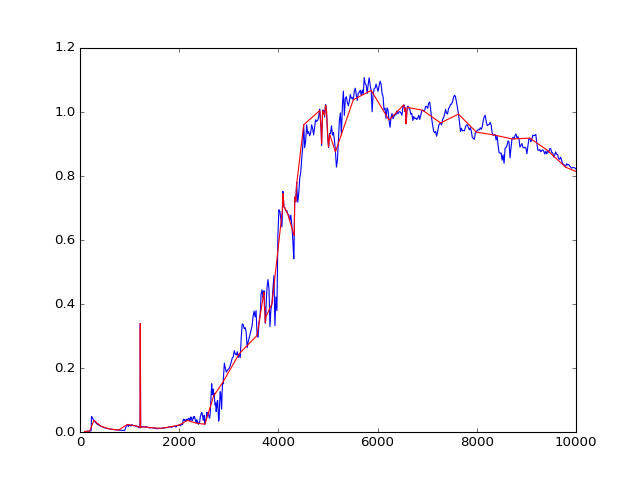

(0, 10000)

In [175]:
#just for checking myself
xt = [x[i] for i in range(0, len(x), 18)]
yt = [y[i] for i in range(0, len(y), 18)]

plt.close()
plt.plot(x,y)
plt.plot(xt, yt, color = 'red')
plt.xlim(0,10000)

# End

In [181]:
L = np.ones((5, len(n_list), len(z_list)))
print(np.shape(L))


# The main cycle
for k in range (L.shape[0]):
    # Data from template
    x = np.genfromtxt(list[k])[:, 0]
    y = np.genfromtxt(list[k])[:, 1]

    for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil, mar[:,1],  mar[:,0], mar[:,2])
        for i in range(len(n_list)):
            #       print(i,j)
            L[k,i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))


Res = np.amin(L, axis=0)


(5, 180, 180)


In [182]:
Res
K = np.amin(Res, axis = 0)
print(K)

[ 15.65831432  15.77481399  15.71412469  15.67831236  15.66327307
  15.6811283   15.74151479  15.68263847  15.6904056   15.71020511
  15.67488173  15.78599364  15.79310968  15.8243859   15.71018803
  15.67362633  15.74252337  15.67679355  15.71151355  15.59662843
  15.53858907  15.62415942  15.70898874  15.7376941   15.82478064
  15.76294423  15.40162303  15.66908505  15.53828407  15.56872891
  15.54831926  15.62917607  15.58928498  15.59217726  15.80689639
  15.94667225  15.15067137  15.79373817  15.63732697  15.50429142
  15.69559173  15.48125039  15.22166288  15.45765509  15.2543332
  15.35607864  15.51111274  15.64241598  15.70251199  15.81037738
  15.89122156  15.89025967  15.87578889  15.86056312  15.84305874
  15.84033832  15.82222967  15.79180933  15.82811283  15.83941277
  15.86147307  15.8607557   15.87362535  15.89425113  15.89594506
  15.88352416  15.87477238  15.87436837  15.89356532  15.88460054
  15.88247477  15.85552528  15.90339931  15.84617609  15.85566296
  15.809068

<IPython.core.display.Javascript object>


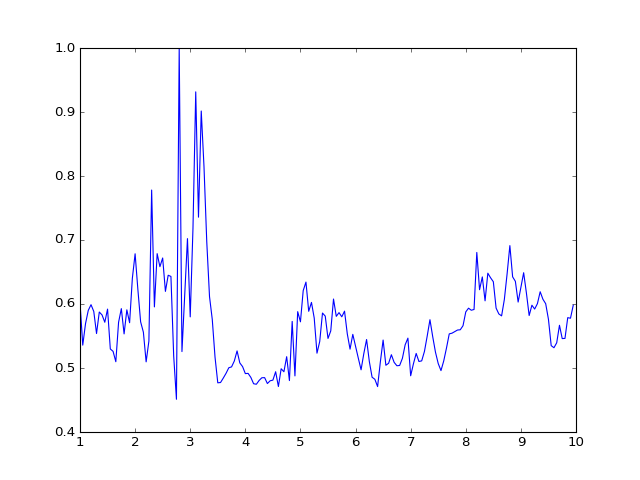

In [184]:
plt.close()
plt.plot( z_list, np.exp(-(K - min(K))))
plt.show()